### Notebook to report on current data availability for Sam and Blanche
Script to report how much data we have per monkey

Things we want to report:
- total number of sessions
- number of trials per session (maybe as histogram?)
- number of units 
- number of units per session (maybe also has histogram?)
- Per feature statistics
- Per pair statistics

In [1]:
import numpy as np
import pandas as pd
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.io_utils as io_utils
import os
from distutils.util import strtobool

import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scripts.anova_analysis.anova_configs import *


### Constants, helper functions

In [2]:
SESS_BEHAVIOR_PATH = "/data/patrick_res/behavior/{sub}/{sess_name}_object_features.csv"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
UNITS_PATH = "/data/patrick_res/firing_rates/{sub}/all_units.pickle"
OUTPUT_DIR= "/data/patrick_res/sessions/reports"

SUBJECTS = ["SA", "BL"]
BLOCK_THESH = 3

In [3]:
def load_beh(sub, sess):
    behavior_path = SESS_BEHAVIOR_PATH.format(
        sess_name=sess,
        sub=sub
    )
    beh = pd.read_csv(behavior_path)
    # beh = behavioral_utils.get_valid_trials(beh, sub)
    beh = behavioral_utils.get_valid_trials(beh, "SA")
    
    beh["session"] = sess
    return beh


def gen_overall_stats():
    both = []
    for sub in SUBJECTS:
        units = pd.read_pickle(UNITS_PATH.format(sub=sub))
        n_sessions = units.session.nunique()
        print(f"{sub}: {len(units)} units across {n_sessions} sessions, avg {len(units) / n_sessions :.2f} units/session")
        n_units = units.groupby("session").PseudoUnitID.nunique().reset_index(name="n_units")
        n_units["sub"] = sub
        both.append(n_units)
    both = pd.concat(both)
    fig, ax = plt.subplots()
    sns.histplot(both, x="n_units", hue="sub", stat="probability", bins=15, ax=ax)
    ax.set_title("Number of units recorded in by session")

def gen_trials_per_session():
    both = []
    for sub in SUBJECTS: 
        valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
        units = pd.read_pickle(UNITS_PATH.format(sub=sub))
        spike_sorted_sess = units.session.unique()
        valid_sess = valid_sess[valid_sess.session_name.isin(spike_sorted_sess)]
        behs = pd.concat(valid_sess.apply(lambda x: load_beh(sub, x.session_name), axis=1).values)
        n_trials = behs.groupby("session").TrialNumber.nunique().reset_index(name="n_trials")
        print(f"{sub}: average {n_trials.n_trials.mean():.2f} trials per session")
        n_trials["sub"] = sub
        both.append(n_trials)
    both = pd.concat(both)
    fig, ax = plt.subplots()
    sns.histplot(both, x="n_trials", hue="sub", stat="probability", bins=15, ax=ax)
    ax.set_title("Number of trials by session")


def gen_per_feat_stats(sub):
    valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
    units = pd.read_pickle(UNITS_PATH.format(sub=sub))
    spike_sorted_sess = units.session.unique()
    valid_sess = valid_sess[valid_sess.session_name.isin(spike_sorted_sess)]
    behs = pd.concat(valid_sess.apply(lambda x: load_beh(sub, x.session_name), axis=1).values)
    sess_per_feat = behavioral_utils.get_good_sessions_per_rule(behs, BLOCK_THESH)
    sess_per_feat["n_units"] = sess_per_feat.apply(lambda x: len(units[units.session.isin(x.sessions)]), axis=1)
    
    args = argparse.Namespace(
        **AnovaConfigs()._asdict()
    )
    args.trial_event = "StimOnset"
    args.conditions = ["FeatPreferred"]
    args.subject = sub
    # args.conditions = ["Response", "Choice"]
    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    good_pref_res = io_utils.read_anova_good_units(args, "95th", return_pos=False)
    pref_units_per_feat = good_pref_res.groupby("feat").PseudoUnitID.nunique().reset_index(name="n_pref_units")

    res_per_feat = pd.merge(sess_per_feat, pref_units_per_feat, on="feat", how="outer")
    res_per_feat["frac_pref"] = res_per_feat.n_pref_units / res_per_feat.n_units
    return res_per_feat

def gen_per_pair_stats(sub):
    valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
    units = pd.read_pickle(UNITS_PATH.format(sub=sub))
    spike_sorted_sess = units.session.unique()
    valid_sess = valid_sess[valid_sess.session_name.isin(spike_sorted_sess)]
    behs = pd.concat(valid_sess.apply(lambda x: load_beh(sub, x.session_name), axis=1).values)
    sess_per_pairs = behavioral_utils.get_good_pairs_across_sessions(behs, BLOCK_THESH)
    sess_per_pairs["n_units"] = sess_per_pairs.apply(lambda x: len(units[units.session.isin(x.sessions)]), axis=1)

    args = argparse.Namespace(
        **AnovaConfigs()._asdict()
    )
    args.trial_event = "StimOnset"
    args.conditions = ["FeatPreferred"]
    args.subject = sub
    # args.conditions = ["Response", "Choice"]
    args.beh_filters = {"Response":"Correct","Choice":"Chose","PreferredChosen":True}
    good_pref_res = io_utils.read_anova_good_units(args, "95th", return_pos=False)
    good_pref_res["session"] = (good_pref_res.PseudoUnitID / 100).astype(int).astype(str)
    sess_per_pairs["n_pref_units"] = sess_per_pairs.apply(
        lambda x: good_pref_res[
            (good_pref_res.feat.isin(x.pair)) & 
            (good_pref_res.session.isin(x.sessions))
        ].PseudoUnitID.nunique(), 
        axis=1
    )
    sess_per_pairs["frac_pref"] = sess_per_pairs.n_pref_units / sess_per_pairs.n_units
    return sess_per_pairs

### In general, how many units do we have per monkey? Recorded across how many sessions?
- Sam had 220 channels
- Blanche had 124


SA: 1279 units across 45 sessions, avg 28.42 units/session
BL: 419 units across 29 sessions, avg 14.45 units/session


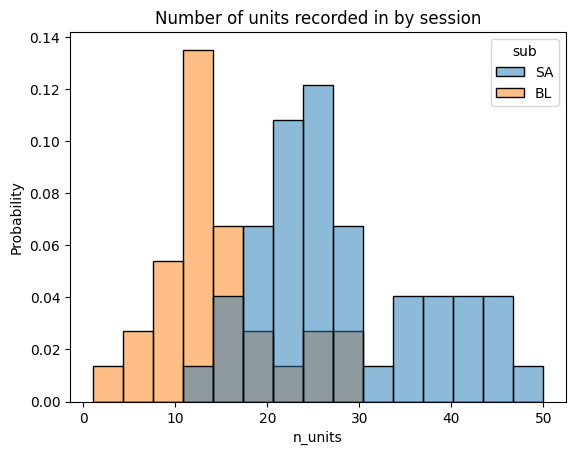

In [4]:
gen_overall_stats()

### How many trials do we have per monkey? Recorded across how many sessions?
NOTE: currently plotting valid trials as defined for Sam:
- not the first two blocks, not the last block, block must be longer than 8
- must have correct/incorrect response

Blanche is older, tired out more easily

SA: average 997.84 trials per session
BL: average 741.03 trials per session


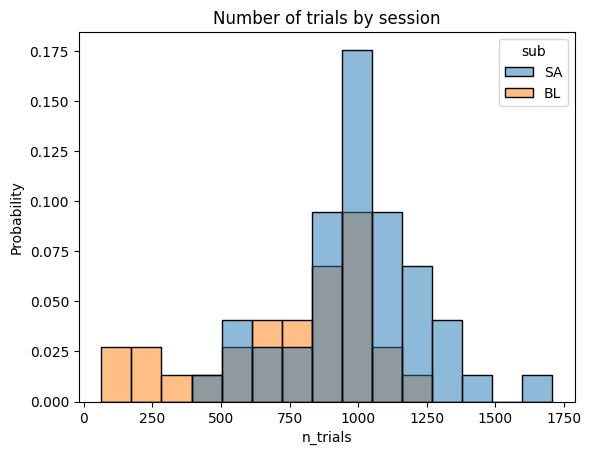

In [5]:
gen_trials_per_session()

### Per-feature stats
Often we want to look at belief/preference analysis per feature, ex. If feature X is preferred or not. To ensure we have enough trials, and to avoid nonsense correlations, For each feature, we find the sessions where the feature shows up at least 3 times as the rule. 
- How many sessions per feature?
- How many units per feature?
- How many "preferred" units do we get for that feature as defined by ANOVA on -1 to 1s between StimOnset?
- What is the fraction of preferred units?

#### For Sam

In [8]:
res = gen_per_feat_stats("SA")

In [9]:
res

,feat,sessions,num_sessions,n_units,n_pref_units,frac_pref
0,CIRCLE,"[20180615, 20180625, 20180709, 20180802, 20180...",22,635,49,0.077165
1,SQUARE,"[20180615, 20180709, 20180801, 20180802, 20180...",22,636,34,0.053459
2,STAR,"[20180709, 20180803, 20180817, 20180821, 20180...",15,384,30,0.078125
3,TRIANGLE,"[20180615, 20180705, 20180801, 20180802, 20180...",11,353,27,0.076487
4,CYAN,"[20180705, 20180801, 20180802, 20180803, 20180...",19,562,45,0.080071
5,GREEN,"[20180802, 20180806, 20180808, 20180813, 20180...",19,514,42,0.081712
6,MAGENTA,"[20180622, 20180705, 20180801, 20180802, 20180...",21,601,36,0.059900
7,YELLOW,"[20180705, 201807250001, 20180801, 20180802, 2...",25,693,52,0.075036
8,ESCHER,"[20180803, 20180808, 20180810, 20180813, 20180...",17,411,29,0.070560
9,POLKADOT,"[20180705, 20180709, 20180802, 20180803, 20180...",19,512,29,0.056641


#### Averages for Sam

In [10]:
res.mean()

/tmp/ipykernel_847699/2084554795.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  res.mean()


num_sessions     18.250000
n_units         512.416667
n_pref_units     35.833333
frac_pref         0.070293
dtype: float64

#### For Blanche

In [11]:
res = gen_per_feat_stats("BL")

In [12]:
res.sort_values(by="n_units", ascending=False)

,feat,sessions,num_sessions,n_units,n_pref_units,frac_pref
8,ESCHER,"[20190220, 20190226, 20190529, 20190530, 20190...",11,169,14,0.082840
2,STAR,"[20190128, 20190226, 20190524, 20190605, 20190...",8,95,11,0.115789
11,SWIRL,"[20190215, 20190524, 20190529, 20190625, 20190...",7,87,6,0.068966
10,RIPPLE,"[20190524, 20190529, 20190611, 20190617, 20190...",7,81,6,0.074074
4,CYAN,"[20190207, 20190531, 20190617, 20190627, 20190...",5,73,3,0.041096
3,TRIANGLE,"[20190606, 20190702, 20190709, 20190710, 20190...",5,62,6,0.096774
7,YELLOW,"[20190524, 20190605, 20190617, 20190703, 20190...",5,55,2,0.036364
6,MAGENTA,"[20190530, 20190703, 20190815, 20190823]",4,52,1,0.019231
9,POLKADOT,"[20190531, 20190605, 20190606, 20190816]",4,42,2,0.047619
1,SQUARE,"[20190524, 20190530, 20190702]",3,30,3,0.100000


#### Average for Blanche

In [13]:
res.mean()

/tmp/ipykernel_847699/2084554795.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  res.mean()


num_sessions     5.166667
n_units         64.750000
n_pref_units     5.000000
frac_pref        0.091560
dtype: float64

#### Notes for Single Feature: 
- Not sure if there's enough preferred units per feature to do population analyses for Blanche (Also haven't tried)

### Per-pair stats
We might also be interested in how belief (or preference) representation changes across features. Similarly to ensure we hav enough trials and prevent nonsense correlations, we'll look for sessions for pairs of features, in each session, both features show up at least 3 times as the rule. 
- How many sessions per feature?
- How many units per feature?
- How many "preferred" units do we get for that feature as defined by ANOVA on -1 to 1s between StimOnset? Here we define a "preferred" unit as one that's preference selective for either of the pair of features.
- What is the fraction of preferred units?

Plot the first 20 pairs, sorted by total number of units

#### For Sam

In [16]:
sa_res = gen_per_pair_stats("SA")
sa_res.sort_values(by="n_units", ascending=False)[:20]

,pair,sessions,num_sessions,dim_type,n_units,n_pref_units,frac_pref
0,"[CIRCLE, SQUARE]","[20180615, 20180709, 20180802, 20180803, 20180...",14,within dim,415,54,0.130120
40,"[CYAN, YELLOW]","[20180705, 20180801, 20180802, 20180820, 20180...",14,within dim,412,58,0.140777
13,"[SQUARE, CYAN]","[20180801, 20180802, 20180803, 20180820, 20180...",11,across dim,348,39,0.112069
6,"[CIRCLE, YELLOW]","[20180802, 20180810, 20180813, 20180821, 20180...",13,across dim,342,58,0.169591
39,"[CYAN, MAGENTA]","[20180705, 20180801, 20180802, 20180803, 20180...",11,within dim,338,49,0.144970
15,"[SQUARE, MAGENTA]","[20180801, 20180802, 20180803, 20180806, 20180...",11,across dim,333,34,0.102102
51,"[MAGENTA, YELLOW]","[20180705, 20180801, 20180802, 20180820, 20180...",11,within dim,332,33,0.099398
16,"[SQUARE, YELLOW]","[20180801, 20180802, 20180810, 20180820, 20180...",12,across dim,332,36,0.108434
46,"[GREEN, YELLOW]","[20180802, 20180813, 20180829, 20180904, 20180...",12,within dim,322,45,0.139752
10,"[CIRCLE, SWIRL]","[20180615, 20180709, 20180802, 20180803, 20180...",9,across dim,305,41,0.134426


#### For Blanche

In [18]:
bl_res = gen_per_pair_stats("BL")
bl_res.sort_values(by="n_units", ascending=False)[:20]

,pair,sessions,num_sessions,dim_type,n_units,n_pref_units,frac_pref
61,"[ESCHER, RIPPLE]","[20190529, 20190617, 20190710, 20190816, 20190...",5,within dim,73,13,0.178082
62,"[ESCHER, SWIRL]","[20190529, 20190627, 20190814, 20190823]",4,within dim,60,8,0.133333
65,"[RIPPLE, SWIRL]","[20190524, 20190529, 20190823]",3,within dim,40,8,0.200000
34,"[TRIANGLE, ESCHER]","[20190710, 20190814]",2,across dim,33,6,0.181818
41,"[CYAN, ESCHER]","[20190531, 20190617, 20190627]",3,across dim,33,4,0.121212
52,"[MAGENTA, ESCHER]","[20190530, 20190823]",2,across dim,29,4,0.137931
26,"[STAR, ESCHER]",[20190226],1,across dim,29,2,0.068966
25,"[STAR, YELLOW]","[20190524, 20190605, 20190703]",3,across dim,29,4,0.137931
40,"[CYAN, YELLOW]","[20190617, 20190815]",2,within dim,26,2,0.076923
51,"[MAGENTA, YELLOW]","[20190703, 20190815]",2,within dim,23,1,0.043478


### General Discussion: 
Unsure if we have enough units currently for Blanche to do population-level analysis we'd like to do. 
- Is this an issue? 
- Thoughts about combining populations?